# Covariance Emulator Demo notebook  

The purpose of this notebook is to give you an introduction on how to design, train, and test a neural network emulator that you can use in a cosmological data analysis.  
One of the ingredients to modern cosmological inference is the **covariance matrix**  This object is notoriously expensive to calculate, so let's try using machine learning to speed up the process!

This notebook is designed to be run on a typical laptop. At the end of this demo, you should be able to:
- Gain some familiarity with how neural networks are designed and trained
- TODO: fill out this list

## Step 1 - Install  

This demo uses the `CovNet` package designed by Joe Adamo to emulate covariance matrices. You'll need to download the associated github repository here: https://github.com/jadamo/CovNet. The next few cells will let you install this repo and make sure it works

In [1]:
# Change this line to wherever you downloaded the repository
%cd /home/joeadamo/Research/CovNet

# install CovNet so you can use it anywhere on your computer
# This should also install all necesary dependencies
#!python -m pip install .

/home/joeadamo/Research/CovNet


In [2]:
# run CovNet unit tests (if all of these pass, everything "should" work
!python -m unittest tests/test_enviornment.py
!python -m unittest tests/test_network.py
#!python -m unittest tests/test_CovaPT.py

/home/joeadamo/Research/CovNet/data/
.
----------------------------------------------------------------------
Ran 1 test in 0.000s

OK
...
----------------------------------------------------------------------
Ran 3 tests in 0.258s

OK


In [3]:
from CovNet import Emulator
from CovNet import Dataset
import torch
from torch.nn import functional as F
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams['figure.facecolor'] = 'white'

## Step 2 - Loading in the training set  

We need a training set to base our emulator on! Normally, building this set would depend on what you want your emulator to do, and is arguably more important than the network itself. Since we're building a network to generate covariance matrices at different cosmologies, we want to make sure the training set properly spans the range of input parameters we care about. 

For this demo, we'll use a small mock training set that I pre-computed such that you should be able to do everything on a laptop. There are $~8000$ matrices in total, each of which are 20x20. This data is accessed using the custom `MatrixDataset` class, which takes:
* the directory your training data is stored
* string specifying if this is the "training", "validation", or "testing" set
* whether to only store part of the covariance matrix (the "Gaussian" term)
* normalization value for positive values of matrices in the training set
* normalization value for negative values of matrices in the training set

In [4]:
# TODO: Update this directory with the location you saved the training set at!
training_dir = "/home/joeadamo/Research/Data/CovNet-Data/TIMESTEP-Training-Set/"

# load and pre-process the training set as a MatrixDataset class
# Setting norm_pos and norm_neg to 0 tells CovNet to compute them from the input data
train_data = Dataset.MatrixDataset(training_dir, "training", 1., False, 0., 0)
norm_pos, norm_neg = train_data.norm_pos.item(), train_data.norm_neg.item()

# load and pre-process the validation and test sets
valid_data = Dataset.MatrixDataset(training_dir, "validation", 1., False, norm_pos, norm_neg)
test_data = Dataset.MatrixDataset(training_dir, "testing", 1., False, norm_pos, norm_neg)

## Step 3 - Building the network

Next, we need to define our network architecture. CovNet uses configuration files to do this such that it is easy to tweak the design either in the file directly, or in code before training. Let's first open an example config file to see what we're dealing with

In [5]:
%cat config-files/example_file.yaml

# -----------------------------------------------
# parameters defining the network architecture

# Can be either "MLP" or "MLP-T"
architecture:  MLP-T

# Input dimension of the network. Should be equal to the number of cosmology parameters you're sampling
input_dim  : 6
# Output dimension of the network. Should be equal to your matrix dimensionality
# Note the actual output dimension will be (N + 1) * N / 2 
output_dim : 20

# These parameters define how many ResNet sub-blocks are in the network, as well as their input / output sizes
num_mlp_blocks: 2
mlp_dims: [50, 100, 200]

# These parameters define various aspects of the transformer block
# If you aren't using the transformer block, you can disregard these arguments
patch_size             : [17, 5]
num_transformer_blocks : 5
num_heads              : 5
embedding              : True        # <- whether to apply possitional embedding
dropout_prob           : 0.25         
freeze_mlp             : True        # <- whether to keeep mlp

Clearly, there are quite a few knobs we can tweak! For this demo we'll be usng the "MLP" architectur, so the main structural things we can change are the number of sub-blocks, and the dimensionality of each sub-block  
Let's load in the config file into code such that we can manipulate its contents

In [6]:
config_dict = Dataset.load_config_file("./config-files/example_file.yaml")
print(config_dict)

{'architecture': 'MLP-T', 'input_dim': 6, 'output_dim': 20, 'num_mlp_blocks': 2, 'mlp_dims': [50, 100, 200], 'patch_size': [17, 5], 'num_transformer_blocks': 5, 'num_heads': 5, 'embedding': True, 'dropout_prob': 0.25, 'freeze_mlp': True, 'train_mlp_first': True, 'num_epochs': 300, 'learning_rate': [0.001438, 0.0001, 1e-05], 'batch_size': 600, 'early_stopping_epochs': -1, 'weight_initialization': 'He', 'train_gaussian_only': False, 'start_from_checkpoint': False, 'norm_pos': 1.0, 'norm_neg': 1.0, 'parameter_bounds': [[50, 100], [0.05, 0.3], [0.75, 4.75], [1, 4], [-4, 4], [-3, 3]], 'save_dir': '/Users/JoeyA/Research/CovNet/emulators/ngc_z3/MLP-T/', 'training_dir': '/Users/JoeyA/Research/CovNet/Training-Set-HighZ-NGC/'}


Let's play around with this dictionary to design your own network! The following cell will have you define custom network parameters as you see fit. There are, of course, many more network design choices that aren't included in this dictionary (ex: the specific structure of each sub-block). Even so, the parameters you can change should give you an idea of how to design a network for your specific case. If you want to see the specific structure in more detail, check out `Blocks.py` and `Emulator.py`

In [7]:
# network parameters to be set by YOU!
config_dict.save_dir = "./emulators/example_net/"
config_dict.architecture = "MLP"
config_dict.num_mlp_blocks = 2
config_dict.mlp_dims = [50, 100, 200]

# If you change these you also have to re-define the training / validation / test sets
config_dict.norm_pos = norm_pos
config_dict.norm_neg = norm_neg

Now we've designed the actual network, but there are still more choices we need to make on how to train it! These choices are commonly called **hyperparameters**, and in our case include:
* The batch size to use during training
* the number of epochs to train for (how long to train)
* the initial learning rate
* How many rounds of training to do
* Whether to stop early during training if performance stops improving

We also need to define the **loss function**, which is the quantity we will try to minimize during training. We'll use the "1-norm" loss function, which is given by:
$$L = \sum_{i,j} \left| C_{i,j}^\text{true} - C_{i,j}^\text{network} \right|$$
You can see from the formula that we go through each element of a matrix we emulate and calculate the absolute difference from the "true" value in the training set. We then sum all of these differences to get one loss value for each matrix. As we'll see later, this value will be the main metric for determining how well our network can emulate covariance matrices

Use the next cell to define a training scheme yourself.

In [8]:
# Training parameters to be set by YOU!
config_dict.weight_initialization = "He"
config_dict.num_epochs = 300
config_dict.learning_rate = [1e-3]
config_dict.batch_size = 100
config_dict.early_stopping_epochs = -1

Now that we've defined all our training and network parameters, it's time to actually build the network itself! `CovNet` does this using the `Network_Emulator` class that takes a dictionary of parameters as input

**NOTE** at this point PyTorch lets you make the optional decision of defining things on a GPU if one is available on you rmachine. Training on GPU is almost always preferable to CPU in terms of performance, but for this demo you shoulnd't have to worry about that. I've left the code that handles GPU compatability here for completeness 

In [9]:
net = Emulator.Network_Emulator(config_dict).to(Dataset.try_gpu())

## Step 4 - Train the network

In [10]:
for i in range(len(config_dict.learning_rate)):
    t1 = time.time()
    optimizer = torch.optim.Adam(net.parameters(), lr=config_dict.learning_rate[i])
    net.Train(optimizer, train_data, valid_data, True, config_dict.save_dir, i)
    t2 = time.time()
    print("Round {:0.0f} done training network!, took {:0.0f} minutes {:0.2f} seconds\n".format(i+1, int((t2 - t1)/60), (t2 - t1)%60))

Epoch : 0, avg train loss: 24.198	 avg validation loss: 24.475	 (0)
Epoch : 1, avg train loss: 13.895	 avg validation loss: 14.199	 (0)
Epoch : 2, avg train loss: 11.391	 avg validation loss: 11.667	 (0)
Epoch : 3, avg train loss: 10.533	 avg validation loss: 10.774	 (0)
Epoch : 4, avg train loss: 9.366	 avg validation loss: 9.589	 (0)
Epoch : 5, avg train loss: 9.076	 avg validation loss: 9.349	 (0)
Epoch : 6, avg train loss: 8.335	 avg validation loss: 8.607	 (0)
Epoch : 7, avg train loss: 7.923	 avg validation loss: 8.130	 (0)
Epoch : 8, avg train loss: 7.654	 avg validation loss: 7.913	 (0)
Epoch : 9, avg train loss: 7.486	 avg validation loss: 7.720	 (0)
Epoch : 10, avg train loss: 7.444	 avg validation loss: 7.670	 (0)
Epoch : 11, avg train loss: 6.942	 avg validation loss: 7.164	 (0)
Epoch : 12, avg train loss: 7.129	 avg validation loss: 7.425	 (1)
Epoch : 13, avg train loss: 6.787	 avg validation loss: 7.077	 (0)
Epoch : 14, avg train loss: 6.593	 avg validation loss: 6.906	 (

## Step 5 - Test the network  

Our main metric for how our network did is the average loss for the test set. To do this we'll use a helper class called `CovNet` that allows us to output covariance matrices from a trained network more easily. This is the class you would call during an MCMC analysis.

In [11]:
cov_emulator = Emulator.CovNet(net.config_dict.save_dir)

The following cell computes the average test loss, and compares it to the final average loss for the training and validation sets.

In [13]:
train_loss = cov_emulator.get_avg_loss(train_data)
valid_loss = cov_emulator.get_avg_loss(valid_data)
test_loss =  cov_emulator.get_avg_loss(test_data)

train_loss_2 = Dataset.get_avg_loss(net, train_data)

print("Average training set loss = {:0.4f}".format(train_loss))
print("Average validation set loss = {:0.4f}".format(valid_loss))
print("Average testing set  loss = {:0.4f}".format(test_loss))

Average training set loss = 4.3617
from net object: 4.3617
Average validation set loss = 4.8332
Average testing set  loss = 4.7968


final validation loss = 4.833


Text(0, 0.5, 'average loss')

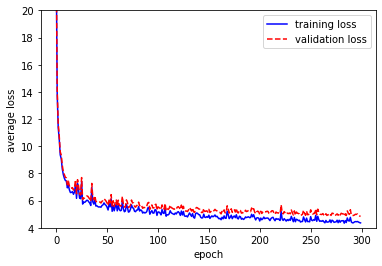

In [14]:
training_data = torch.load("/home/joeadamo/Research/CovNet/emulators/example_net/train_data-MLP.dat", map_location=Dataset.try_gpu())
epochs = training_data[0,:]    
round_start = torch.where(epochs == 0)[0]
train_loss = training_data[1,:]
valid_loss = training_data[2,:]

print("final validation loss = {:0.3f}".format(torch.min(valid_loss)))

plt.plot(range(len(epochs)), train_loss, color="blue", label="training loss")
plt.plot(range(len(epochs)), valid_loss, color="red", ls="--", label="validation loss")
plt.ylim(4, 20)
for i in range(1, len(round_start)):
    plt.axvline(round_start[i], c="black", ls="--")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("average loss")

Let's dig a little deeper and try visualizing how accurately our network can generate individual matrices.

sample 511, params: [82.760216    0.16121744  2.503405    3.4073157   1.6669979  -0.9714113 ]
Loss value = 1.952
error per entry: mean = 6.274%, median = 1.575%


/tmp/ipykernel_539439/3209735192.py:15: RuntimeWarning: invalid value encountered in true_divide
  error = abs((cov_predict - cov_actual) / cov_actual).flatten()


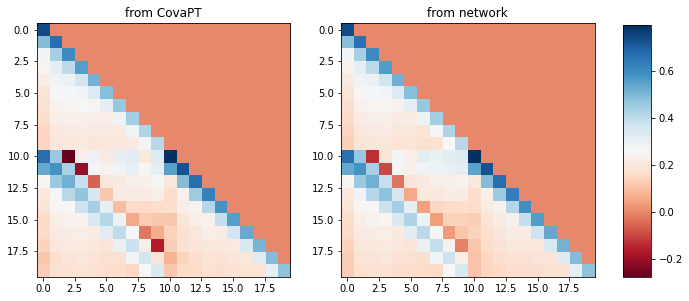

In [15]:
# first, let's look at the raw emulator output, with pre-processing still applied
idx = np.random.randint(0, len(test_data))

params = test_data[idx][0].detach().numpy()
cov_actual = test_data[idx][1].detach()
cov_predict = cov_emulator.get_covariance_matrix(params, raw=True).detach().view(20,20)

RLoss = F.l1_loss(cov_predict, cov_actual, reduction="sum")

print("sample " + str(idx) + ", params:", params)
print("Loss value = {:0.3f}".format(RLoss))

cov_predict = cov_predict.numpy()
cov_actual = cov_actual.numpy()
error = abs((cov_predict - cov_actual) / cov_actual).flatten()
error = error[(np.isnan(error) == False)]
print("error per entry: mean = {:0.3f}%, median = {:0.3f}%".format(100*np.mean(error), 100*np.median(error)))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title("from CovaPT")
axs[1].set_title("from network")
img = axs[0].imshow(cov_actual, cmap="RdBu")
img = axs[1].imshow(cov_predict, cmap="RdBu", vmin=np.amin(cov_actual), vmax=np.amax(cov_actual))

cbar_ax = fig.add_axes([0.94, 0.15, 0.039, 0.7])
cbar = fig.colorbar(img, cax=cbar_ax)

trace(C) = 5.074e+08,	 actual = 1.073e+07,	 error=4627.703%
det(C) = 276.82,	 actual = 212.978,	 error=29.974%
cond(C) = 1.60e+04,	 actual = 5.82e+03


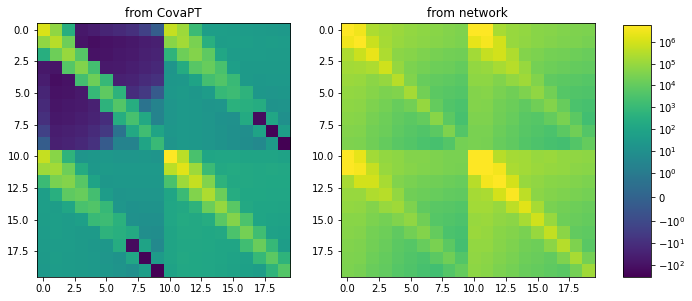

In [16]:
# Now let's look at the actual covariance matrix without pre-processing
cov_actual = test_data.get_full_matrix(i)
cov_predict = cov_emulator.get_covariance_matrix(params, raw=False)

# compile some statistics of each matrix and compare them
trace_pred = np.trace(cov_predict)
trace_act = np.trace(cov_actual)
trace_err = 100*(trace_pred - trace_act) / trace_act

det_pred = np.linalg.slogdet(cov_predict)[1]
det_act  = np.linalg.slogdet(cov_actual)[1]
det_err = 100*(det_pred - det_act) / det_act

cond_pred = np.linalg.cond(cov_predict)
cond_act = np.linalg.cond(cov_actual)

print("trace(C) = {:0.3e},\t actual = {:0.3e},\t error={:0.3f}%".format(trace_pred, trace_act, trace_err))
print("det(C) = {:0.2f},\t actual = {:0.3f},\t error={:0.3f}%".format(det_pred, det_act, det_err))
print("cond(C) = {:0.2e},\t actual = {:0.2e}".format(cond_pred, cond_act))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title("from CovaPT")
axs[1].set_title("from network")
img = axs[0].imshow(cov_actual, norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(cov_actual), vmax=np.amax(cov_actual)))
img = axs[1].imshow(cov_predict, norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(cov_actual), vmax=np.amax(cov_actual)))

cbar_ax = fig.add_axes([0.94, 0.15, 0.039, 0.7])
cbar = fig.colorbar(img, cax=cbar_ax)